Project ini digunakan untuk mempersiapkan data sekaligus membuat model prediksi yang tepat untuk menentukan pelanggan akan berhenti berlangganan (churn) atau tidak di suatu perusahaan Telcommunication

In [ ]:
#Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from pathlib import Path

In [ ]:
import pandas as pd
pd.options.display.max_columns = 50 #menampilkan semua kolom
#import dataset
df_load =pd.read_csv('https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/dqlab_telco.csv')

#Tampilkan jumlah baris dan kolom
print(df_load.shape)

#Tampilkan 5 data teratas
print(df_load.head(5))

#Jumlah ID yang unik
print(df_load.customerID.nunique())

(7113, 22)
   UpdatedAt   customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     202006  45759018157  Female              0     Yes         No     1.0   
1     202006  45557574145    Male              0      No         No    34.0   
2     202006  45366876421    Male              0      No         No     2.0   
3     202006  45779536532    Male              0      No         No    45.0   
4     202006  45923787906  Female              0      No         No     2.0   

  PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0           No  No phone service             DSL             No          Yes   
1          Yes                No             DSL            Yes           No   
2          Yes                No             DSL            Yes          Yes   
3           No  No phone service             DSL            Yes           No   
4          Yes                No     Fiber optic             No           No   

  DeviceProtection TechSupport St

In [ ]:
df_load.shape

(7113, 22)

**Data Cleansing**

In [ ]:
df_load['valid_id'] = df_load['customerID'].astype(str).str.match(r'(45\d{9,10})')
df_load = (df_load[df_load['valid_id'] == True]).drop('valid_id', axis = 1)
print('Hasil jumlah ID Customer yang terfilter adalah',df_load['customerID'].count())

Hasil jumlah ID Customer yang terfilter adalah 7006


In [ ]:
df_load.drop_duplicates()
df_load = df_load.sort_values('UpdatedAt',ascending=False).drop_duplicates('customerID')
print('Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya adalah',df_load['customerID'].count())

Hasil jumlah ID Customer yang sudah dihilangkan duplikasinya adalah 6993


In [ ]:
#check Missing Value berapa banyak

print('Total missing values data dari kolom Churn',df_load['Churn'].isnull().sum())

#Dropping all Rows with spesific column

df_load.dropna(subset=['Churn'],inplace=True)
print('Total Rows dan kolom Data setelah dihapus data Missing Values adalah',df_load.shape)

Total missing values data dari kolom Churn 43
Total Rows dan kolom Data setelah dihapus data Missing Values adalah (6950, 22)


In [ ]:
print('Status Missing Values:',df_load.isnull().values.any())
print('\\nJumlah Missing Values masing-masing kolom, adalah:')
print(df_load.isnull().sum().sort_values(ascending=False))

#handling missing values Tenure fill with 11
df_load['tenure'].fillna(11, inplace=True)

#Handling missing values num vars (except Tenure)
for col_name in list(['MonthlyCharges','TotalCharges']):
	median = df_load[col_name].median()
	df_load[col_name].fillna(median, inplace=True)


print('\nJumlah Missing Values setelah di imputer datanya, adalah:')
print(df_load.isnull().sum().sort_values(ascending=False))

Status Missing Values: True
\nJumlah Missing Values masing-masing kolom, adalah:
tenure              99
MonthlyCharges      26
TotalCharges        15
Churn                0
InternetService      0
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
PhoneService         0
MultipleLines        0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
UpdatedAt            0
dtype: int64

Jumlah Missing Values setelah di imputer datanya, adalah:
Churn               0
TotalCharges        0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV

**Check Outlier**


Persebaran data sebelum ditangani Outlier: 
            tenure  MonthlyCharges  TotalCharges
count  6950.000000     6950.000000   6950.000000
mean     32.477266       65.783741   2305.083460
std      25.188910       50.457871   2578.651143
min       0.000000        0.000000     19.000000
25%       9.000000       36.462500    406.975000
50%      29.000000       70.450000   1400.850000
75%      55.000000       89.850000   3799.837500
max     500.000000     2311.000000  80000.000000


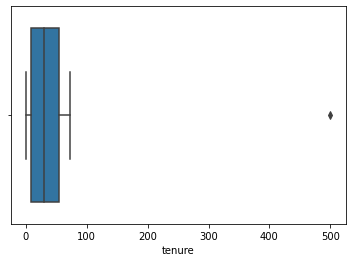

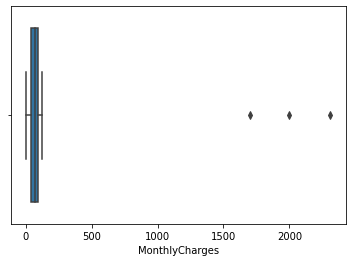

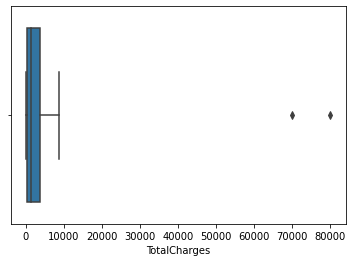

In [ ]:
print('\nPersebaran data sebelum ditangani Outlier: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())

# Creating Box Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Masukkan variable
plt.figure() # untuk membuat figure baru
sns.boxplot(x=df_load['tenure'])
plt.show()

plt.figure() # untuk membuat figure baru
sns.boxplot(x=df_load['MonthlyCharges'])
plt.show()

plt.figure()
sns.boxplot(x=df_load['TotalCharges'])
plt.show()

**Mengatasi Outlier**

In [ ]:
# Handling with IQR
Q1 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.25)
Q3 = (df_load[['tenure','MonthlyCharges','TotalCharges']]).quantile(0.75)

IQR = Q3 - Q1
maximum = Q3 + (1.5*IQR)
print('Nilai Maximum dari masing-masing Variable adalah: ')
print(maximum)
minimum = Q1 - (1.5*IQR)
print('\nNilai Minimum dari masing-masing Variable adalah: ')
print(minimum)

more_than = (df_load > maximum)
lower_than = (df_load < minimum)
df_load = df_load.mask(more_than, maximum, axis=1)
df_load = df_load.mask(lower_than, minimum, axis=1)

print('\nPersebaran data setelah ditangani Outlier: ')
print(df_load[['tenure','MonthlyCharges','TotalCharges']].describe())

Nilai Maximum dari masing-masing Variable adalah: 
tenure             124.00000
MonthlyCharges     169.93125
TotalCharges      8889.13125
dtype: float64

Nilai Minimum dari masing-masing Variable adalah: 
tenure             -60.00000
MonthlyCharges     -43.61875
TotalCharges     -4682.31875
dtype: float64

Persebaran data setelah ditangani Outlier: 
            tenure  MonthlyCharges  TotalCharges
count  6950.000000     6950.000000   6950.000000
mean     32.423165       64.992201   2286.058750
std      24.581073       30.032040   2265.702553
min       0.000000        0.000000     19.000000
25%       9.000000       36.462500    406.975000
50%      29.000000       70.450000   1400.850000
75%      55.000000       89.850000   3799.837500
max     124.000000      169.931250   8889.131250


**Membetulkan data yang tidak rapi**

In [ ]:
for col_name in list(['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']):
	print('\nUnique Values Count\033[1m' + 'Before Standardized \033[0m Variable',col_name)
	print(df_load[col_name].value_counts())


Unique Values CountBefore Standardized  Variable gender
Male         3499
Female       3431
Wanita         14
Laki-Laki       6
Name: gender, dtype: int64

Unique Values CountBefore Standardized  Variable SeniorCitizen
0    5822
1    1128
Name: SeniorCitizen, dtype: int64

Unique Values CountBefore Standardized  Variable Partner
No     3591
Yes    3359
Name: Partner, dtype: int64

Unique Values CountBefore Standardized  Variable Dependents
No     4870
Yes    2060
Iya      20
Name: Dependents, dtype: int64

Unique Values CountBefore Standardized  Variable PhoneService
Yes    6281
No      669
Name: PhoneService, dtype: int64

Unique Values CountBefore Standardized  Variable MultipleLines
No                  3346
Yes                 2935
No phone service     669
Name: MultipleLines, dtype: int64

Unique Values CountBefore Standardized  Variable InternetService
Fiber optic    3057
DSL            2388
No             1505
Name: InternetService, dtype: int64

Unique Values CountBefore Standa

In [ ]:
df_load = df_load.replace(['Wanita','Laki-Laki','Churn','Iya'],['Female','Male','Yes','Yes'])

# Masukkan variable
for col_name in list(['gender','Dependents','Churn']):
  print('\nUnique Values Count \033[1m' + 'After Standardized \033[0mVariable',col_name)
  print(df_load[col_name].value_counts())




Unique Values Count After Standardized Variable gender
Male      3505
Female    3445
Name: gender, dtype: int64

Unique Values Count After Standardized Variable Dependents
No     4870
Yes    2080
Name: Dependents, dtype: int64

Unique Values Count After Standardized Variable Churn
No     5114
Yes    1836
Name: Churn, dtype: int64


**Melakukan Exploratory Data Analysis / Ekplorasi Data**

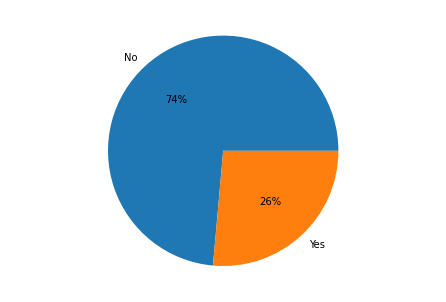

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
#Your codes here
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['No','Yes']
churn = df_load.Churn.value_counts()
ax.pie(churn, labels=labels, autopct='%.0f%%')
plt.show()

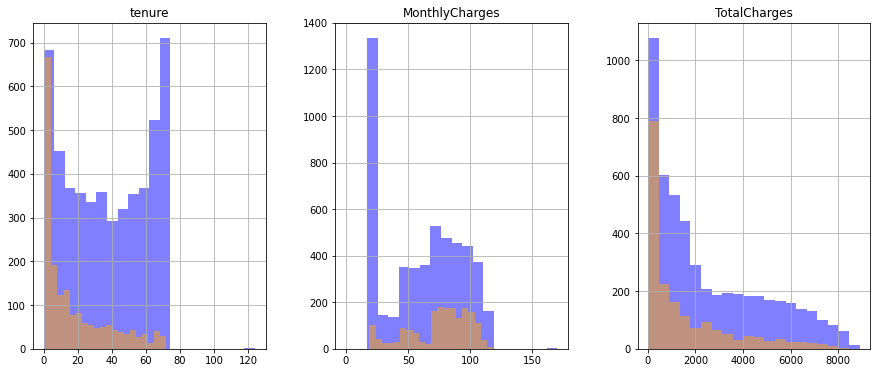

In [ ]:
numerical_features = ['tenure','MonthlyCharges','TotalCharges']
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

df_load[df_load.Churn == 'No'][numerical_features].hist(bins=20, color='blue', alpha=0.5, ax=ax)
df_load[df_load.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax=ax)
plt.show()

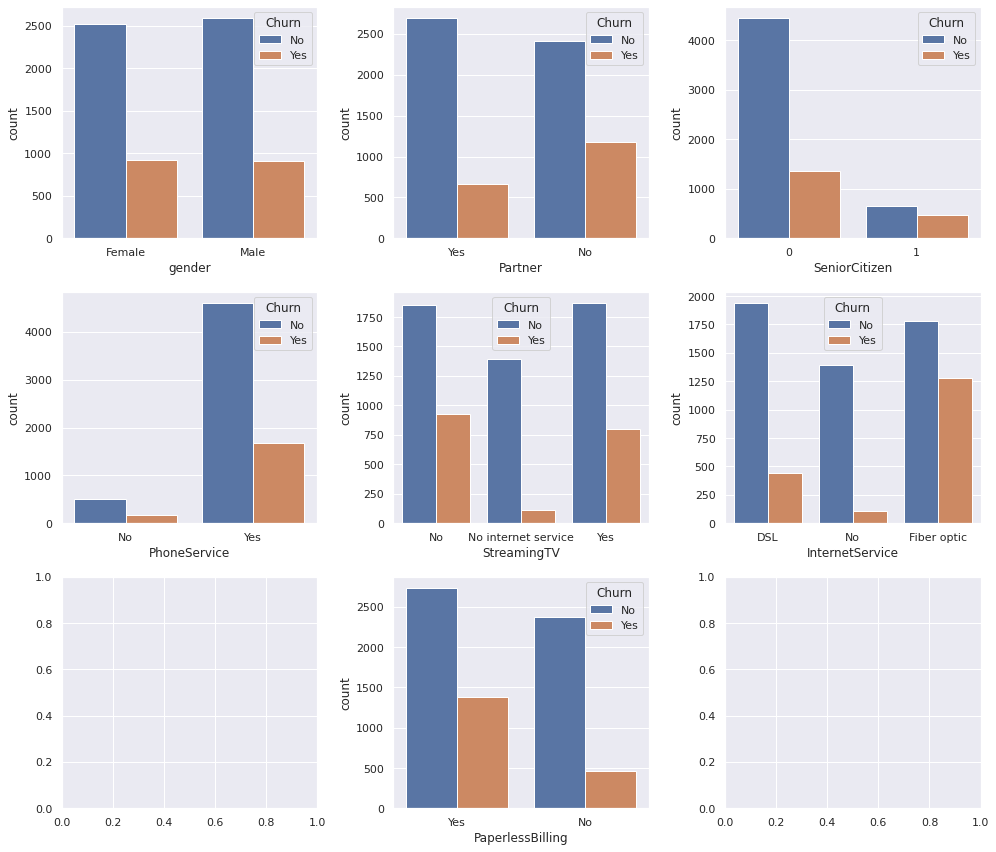

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns 
sns.set(style='darkgrid')
# Your code goes here
fig, ax = plt.subplots(3, 3, figsize=(14, 12))
sns.countplot(data=df_load, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df_load, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df_load, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df_load, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df_load, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df_load, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df_load, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.show()

**Melakukan Data Preprocessing**

In [ ]:
cleaned_df = df_load.drop(['customerID','UpdatedAt'], axis=1)
print(cleaned_df.head())

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No     1.0           No   
4727    Male              0     Yes         No    60.0          Yes   
4738    Male              0      No         No     5.0          Yes   
4737  Female              0     Yes         No    72.0          Yes   
4736  Female              0     Yes        Yes    56.0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
0     No phone service             DSL                   No   
4727                No              No  No internet service   
4738               Yes     Fiber optic                   No   
4737               Yes     Fiber optic                  Yes   
4736               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
0                     Yes                   No                   No   
4727  No internet service  No internet service  No i

In [ ]:
from sklearn.preprocessing import LabelEncoder
#Convert all the non-numeric columns to numerical data types
for column in cleaned_df.columns:
  if cleaned_df[column].dtype == np.number: continue
    # Perform encoding for each non-numeric column
  cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
print(cleaned_df.describe())

            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  6950.000000    6950.000000  6950.000000  6950.000000  6950.000000   
mean      0.504317       0.162302     0.483309     0.299281    32.423165   
std       0.500017       0.368754     0.499757     0.457976    24.581073   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000   124.000000   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
count   6950.000000    6950.000000      6950.000000     6950.000000   
mean       0.903741       0.940863         0.872950        0.789496   
std        0.294967       0.948880         0.737618        0.859795   
min        0.000000       0.000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  after removing the cwd from sys.path.


In [ ]:
from sklearn.model_selection import train_test_split
# Predictor dan target
X = cleaned_df.drop('Churn',axis=1)
y = cleaned_df['Churn']
# Splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)
# Print according to the expected result
print('Jumlah baris dan kolom dari x_train adalah:', X_train.shape,', sedangkan Jumlah baris dan kolom dari y_train adalah:', y_train.shape)
print('Prosentase Churn di data Training adalah:')
print(y_train.value_counts(normalize=True))
print('Jumlah baris dan kolom dari x_test adalah:', X_test.shape,', sedangkan Jumlah baris dan kolom dari y_test adalah:', y_test.shape)
print('Prosentase Churn di data Testing adalah:')
print(y_test.value_counts(normalize=True))

Jumlah baris dan kolom dari x_train adalah: (4865, 19) , sedangkan Jumlah baris dan kolom dari y_train adalah: (4865,)
Prosentase Churn di data Training adalah:
0    0.734841
1    0.265159
Name: Churn, dtype: float64
Jumlah baris dan kolom dari x_test adalah: (2085, 19) , sedangkan Jumlah baris dan kolom dari y_test adalah: (2085,)
Prosentase Churn di data Testing adalah:
0    0.738129
1    0.261871
Name: Churn, dtype: float64


**Menentukan Modelling Machine Learning**

**Model Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression().fit(X_train, y_train)
print('Model Logistic Regression yang terbentuk adalah: \n',log_model)


Model Logistic Regression yang terbentuk adalah: 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn.metrics import classification_report
# Predict
y_train_pred = log_model.predict(x_train)
# Print classification report 
print('Classification Report Training Model (Logistic Regression) : \n', classification_report(y_train, y_train_pred))

Classification Report Training Model (Logistic Regression) : 
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      3575
           1       0.64      0.57      0.60      1290

    accuracy                           0.80      4865
   macro avg       0.74      0.73      0.73      4865
weighted avg       0.79      0.80      0.80      4865



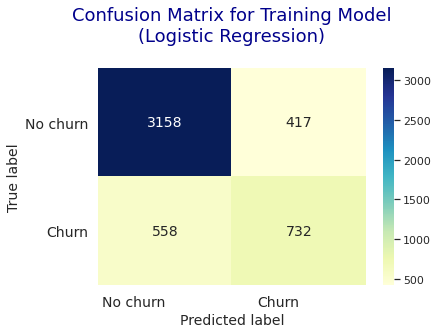

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 14}, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

In [ ]:
# Predict
y_test_pred = log_model.predict(X_test)
# Print classification report 
print('Classification Report Training Model (Logistic Regression) : \n', classification_report(y_test, y_test_pred))

Classification Report Training Model (Logistic Regression) : 
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1539
           1       0.66      0.54      0.60       546

    accuracy                           0.81      2085
   macro avg       0.75      0.72      0.74      2085
weighted avg       0.80      0.81      0.80      2085



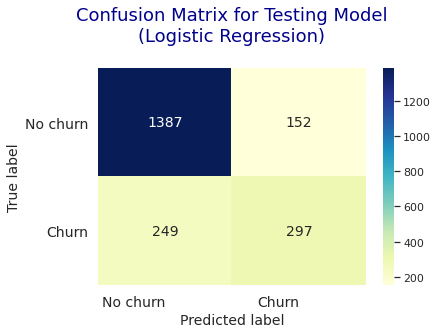

In [ ]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 14}, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

**Model dengan Random Forest Classifier**

In [ ]:
rdf_model = RandomForestClassifier().fit(X_train, y_train)
print(rdf_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
y_train_rdf_pred = rdf_model.predict(X_train)
print('Classification Report Training Model (Random Forest Classifier):')
print(classification_report(y_train, y_train_rdf_pred))

Classification Report Training Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       1.00      1.00      1.00      1290

    accuracy                           1.00      4865
   macro avg       1.00      1.00      1.00      4865
weighted avg       1.00      1.00      1.00      4865



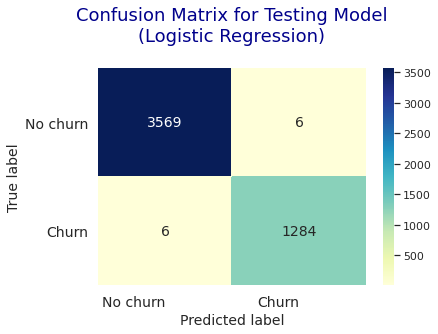

In [ ]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_rdf_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 14}, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.title('Confusion Matrix for Testing Model\n(Random Forest Classifier)\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

In [ ]:
y_test_rdf_pred = rdf_model.predict(X_test)
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_rdf_pred))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1539
           1       0.66      0.49      0.57       546

    accuracy                           0.80      2085
   macro avg       0.75      0.70      0.72      2085
weighted avg       0.79      0.80      0.79      2085



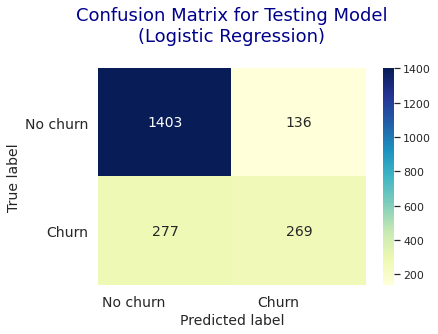

In [ ]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_rdf_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 14}, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.title('Confusion Matrix for Testing Model\n(Random Forest Classifier)\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

**Gradient Boosting Classifier**

In [ ]:
gbc_model = GradientBoostingClassifier().fit(X_train, y_train)
print(gbc_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [ ]:
y_train_gbc_pred = gbc_model.predict(X_train)
print('Classification Report Training Model (Gradient Boosting Classifier):')
print(classification_report(y_train, y_train_gbc_pred))

Classification Report Training Model (Gradient Boosting Classifier):
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3575
           1       0.73      0.58      0.64      1290

    accuracy                           0.83      4865
   macro avg       0.79      0.75      0.77      4865
weighted avg       0.82      0.83      0.82      4865



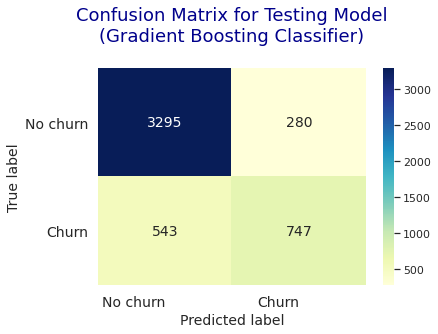

In [ ]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_gbc_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 14}, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.title('Confusion Matrix for Testing Model\n(Gradient Boosting Classifier)\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

In [ ]:
y_test_gbc_pred = gbc_model.predict(X_test)
print('Classification Report Testing Model (Gradient Boosting Classifier):')
print(classification_report(y_test, y_test_gbc_pred))

Classification Report Testing Model (Gradient Boosting Classifier):
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1539
           1       0.68      0.51      0.59       546

    accuracy                           0.81      2085
   macro avg       0.76      0.71      0.73      2085
weighted avg       0.80      0.81      0.80      2085



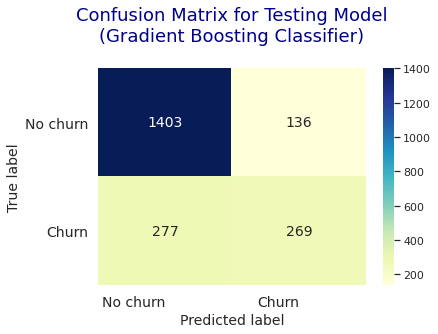

In [ ]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_rdf_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 14}, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
plt.title('Confusion Matrix for Testing Model\n(Gradient Boosting Classifier)\n', fontsize = 18, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()

**Menentukan model terbaik**

In [ ]:
#algoritma terbaik untuk model dalam kasus ini adalah dengan algoritma Logistic Regression dengn akurasi training sebesar 80% sedangkan akurasinya 81%